In [125]:
import os
import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot
#import humanize

pd.set_option('display.max_rows', 500)

import pybedtools as pbt 
pbt.set_bedtools_path('/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/bin/')
pbt.set_tempdir('/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/scratch/')

os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/projects/dchallenge/')

outdir = 'results/main/finemapping/summary/'
os.makedirs(outdir, exist_ok=True)

In [14]:
# loading the gwas label information
gwas_labels = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')
gwas_labels.set_index('gwas_id', inplace=True)

## Inspecting Fine-mapping results 

In [137]:
# loading the finemapping data
data = []
for fn in glob.glob('results/main/finemapping/*/*/*/Summary/sss/FINAL_top_snp_credible_set.txt'):
    
    # get path information
    path_info = fn.split('/')
    
    # load data
    df = pd.read_table(fn)    
    df['gwas_source'] = path_info[3]    
    df['offset'] = path_info[5]
    data.append(df)

In [138]:
finemapping = pd.concat(data)
major_cols = ['gwas_source', 
              'regionID',
              'index',
              'GWASLoci',
              'rsid',
              'chromosome',
              'position',
              'allele1',
              'allele2',
              'maf',
              'beta',
              'se',
              'z',
              'prob',
              'log10bf',
              'mean',
              'sd',
              'mean_incl',
              'sd_incl',
              'pval',
              'offset']
finemapping_major = finemapping[major_cols]
#finemapping_major = finemapping_major.loc[finemapping_major.prob > 0.10]
finemapping_major = finemapping_major.drop_duplicates(['gwas_source', 'rsid'])

In [139]:
# counting the number of 
finemap_sources_cnt = finemapping_major.groupby('gwas_source').rsid.count().to_frame()
finemap_sources_cnt = finemap_sources_cnt.merge(gwas_labels, left_index=True, right_index=True)

In [140]:
finemap_sources_cnt

,rsid,authorship,link
T1D_34012112_Gaulton,101,"Chiou et al., 2021",https://www.ebi.ac.uk/gwas/publications/34012112


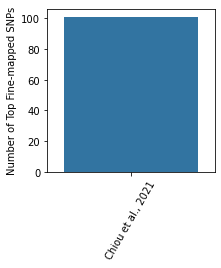

In [141]:
fig, ax = plt.subplots(figsize=(3,3))

sns.barplot(x='authorship', y='rsid', data=finemap_sources_cnt, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Number of Top Fine-mapped SNPs')


ax.set_xticklabels(finemap_sources_cnt['authorship'], rotation = 60)


summary_fn = os.path.join(outdir, 'finemaps_per_study.svg')
fig.savefig(summary_fn)

<AxesSubplot:>

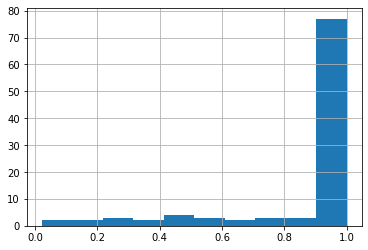

In [142]:
finemapping_major.prob.hist()

<AxesSubplot:xlabel='prob', ylabel='Count'>

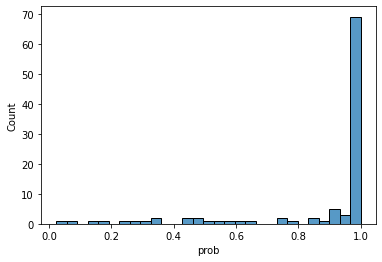

In [143]:
sns.histplot(finemapping_major.prob)

## Characterizing SNPs with Universal ChromHMM from Vu et al 2022

This universal ChromHMM is coming from https://github.com/ernstlab/full_stack_ChromHMM_annotations 

In [144]:
#loading Vu et al 2022 chromHMM annotations 
chromhmm = pd.read_table('results/refs/chromHMM/vu_et_al_2022/hg38lift_genome_100_segments.bed.gz', 
                         header=None)
chromhmm_pbt = pbt.BedTool.from_dataframe(chromhmm)

In [145]:
finemapping_pbt = finemapping_major[['chromosome', 'position', 'position']].drop_duplicates()
finemapping_pbt['chromosome'] = 'chr' + finemapping_pbt['chromosome'].astype(str)
finemapping_pbt.iloc[:, 1] = finemapping_pbt.iloc[:, 1] - 1 # convert to bed format 
finemapping_pbt = pbt.BedTool.from_dataframe(finemapping_pbt)

In [146]:
finemapping_chromhmm = finemapping_pbt.intersect(chromhmm_pbt, loj=True, wa=True)
finemapping_chromhmm = finemapping_chromhmm.to_dataframe()
finemapping_chromhmm.columns = ['chr', 'start', 'end', 'chr2', 'chmm_start', 'chmm_end', 'state']

# extract the statename without the id number
def split_chromhmm(x):
    s = x.split('_')
    if len(s) > 1:
        return(s[1])
    else:
        return('None')
finemapping_chromhmm['state_name'] = finemapping_chromhmm.state.map(split_chromhmm)

# add the major state which removes the subtypes
finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')

/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/scratch//ipykernel_73269/3274623952.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  finemapping_chromhmm['major_state'] = finemapping_chromhmm.state_name.str.replace('[0-9]+', '')


In [147]:
finemapping_chromhmm

,chr,start,end,chr2,chmm_start,chmm_end,state,state_name,major_state
0,chr10,89896900,89896901,chr10,89896843,89897043,5_Quies3,Quies3,Quies
1,chr10,90036366,90036367,chr10,90036243,90036843,5_Quies3,Quies3,Quies
2,chr10,90052526,90052527,chr10,90051843,90053843,54_EnhA13,EnhA13,EnhA
3,chr10,90035653,90035654,chr10,90035243,90036043,5_Quies3,Quies3,Quies
4,chr10,90042008,90042009,chr10,90041643,90042043,28_Acet3,Acet3,Acet
5,chr10,90046745,90046746,chr10,90046443,90049243,40_EnhWk7,EnhWk7,EnhWk
6,chr10,90039354,90039355,chr10,90038843,90040043,5_Quies3,Quies3,Quies
7,chr10,90051034,90051035,chr10,90050843,90051243,54_EnhA13,EnhA13,EnhA
8,chr10,90435506,90435507,chr10,90435243,90435643,34_EnhWk1,EnhWk1,EnhWk
9,chr10,90034038,90034039,chr10,90033443,90034043,5_Quies3,Quies3,Quies


#### Plotting with ALL states

In [148]:
fm_state_cnts = finemapping_chromhmm.state_name.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()
fm_state_cnts.columns = ['counts']
fm_state_cnts['state'] = fm_state_cnts.index

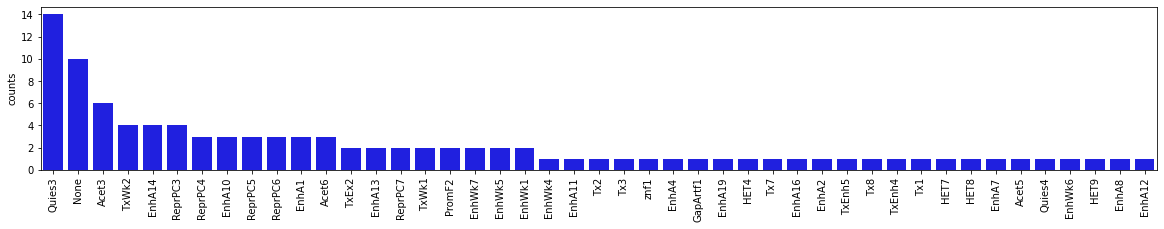

In [149]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(20,3))

sns.barplot(x='state', y='counts', data=fm_state_cnts, color='blue', dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['state'], rotation = 90);

#### Plotting with Major states

In [150]:
state_dict = {'Quies': 'Quiescent',
             'ReprPC': 'Repressor',
             'GapArtf': 'No signal, unmappable',
             'Acet': 'Acetylation',
             'TxWk': 'Weak transcription',
             'EnhWk': 'Weak enhancer',
             'None': 'No overlap',
             'Tx': 'Transcription',
             'EnhA': 'Enhancer',
             'TxEx': 'Transcription & Exons',
             'HET': 'H3K9me3 & LTR repeats',
             'TxEnh': 'Transcription & Enhancers',
             'BivProm': 'Bivalent Promoters',
             'znf': 'Zinc Finger',
             'PromF': 'Downstream Promoter',
             'DNase': 'DNase',
             'TSS': 'TSS'}

state_colors = {'Quies': 'grey',
             'ReprPC': 'grey',
             'GapArtf': 'grey',
             'Acet': 'grey',
             'None': 'grey',
             'HET': 'grey',
             'EnhWk': 'lightYellow',
             'EnhA': 'yellow',
             'TxWk': 'lightGreen',
             'Tx': 'darkgreen',
             'TxEx': 'darkgreen',
             'TxEnh': 'darkgreen',
             'DNase': 'blue',
             'znf': 'blue', 
             'BivProm': 'red',
             'PromF': 'red',
             'TSS': 'red'}

fm_state_cnts = finemapping_chromhmm.major_state.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()

In [151]:
fm_state_cnts

,major_state
EnhA,20
Quies,15
ReprPC,15
Acet,10
None,10
EnhWk,8
TxWk,6
Tx,5
HET,4
PromF,2


In [152]:
fm_state_cnts.columns = ['counts']
fm_state_cnts['major_state'] = fm_state_cnts.index

In [153]:
fm_state_cnts

,counts,major_state
EnhA,20,EnhA
Quies,15,Quies
ReprPC,15,ReprPC
Acet,10,Acet
None,10,None
EnhWk,8,EnhWk
TxWk,6,TxWk
Tx,5,Tx
HET,4,HET
PromF,2,PromF


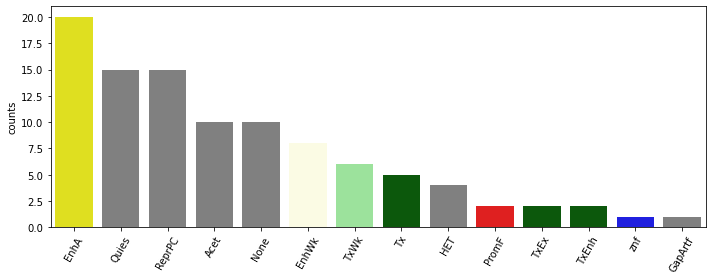

In [154]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(x='major_state', y='counts', data=fm_state_cnts, hue='major_state', palette=state_colors, dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['major_state'], rotation = 60);

# ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1.1),
#           fancybox=True, shadow=False)

ax.legend_.set_visible(False)

chromhmm_summary_fn = os.path.join(outdir, 'finemapped_snps_characterized_chromhmm.svg')
fig.savefig(chromhmm_summary_fn)

chromhmm_summary_fn = os.path.join(outdir, 'finemapped_snps_characterized_chromhmm.png')
fig.tight_layout()
fig.savefig(chromhmm_summary_fn, dpi=1600, )

## Further investigation

Checking the number of regions per GWAS SS.

In [155]:
finemapping_major.groupby(['gwas_source']).regionID.nunique()

gwas_source
T1D_34012112_Gaulton    10
Name: regionID, dtype: int64

Why do the regions of **T1D_34012112_Gaulton** have so few regions? It should have a lot because it was complete with a lot of datasets. 

In [156]:
finemapping_major

,gwas_source,regionID,index,GWASLoci,rsid,chromosome,position,allele1,allele2,maf,...,se,z,prob,log10bf,mean,sd,mean_incl,sd_incl,pval,offset
0,T1D_34012112_Gaulton,16,1885,chr10:89512436-90644950,10:89896901,10,89896901,C,CT,0.087600,...,0.031033,0.482261,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,3.148103e-01,offset_1000000
1,T1D_34012112_Gaulton,16,2514,chr10:89512436-90644950,10:90036367,10,90036367,G,C,0.222000,...,0.017116,-9.094710,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,1.000000e+00,offset_1000000
2,T1D_34012112_Gaulton,16,2582,chr10:89512436-90644950,10:90052527,10,90052527,A,G,0.036300,...,0.037187,-2.396540,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,9.917246e-01,offset_1000000
3,T1D_34012112_Gaulton,16,2511,chr10:89512436-90644950,10:90035654,10,90035654,A,C,0.278000,...,0.015736,-9.613120,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,1.000000e+00,offset_1000000
4,T1D_34012112_Gaulton,16,2535,chr10:89512436-90644950,10:90042009,10,90042009,T,C,0.000107,...,1.011960,-0.703131,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,7.590122e-01,offset_1000000
5,T1D_34012112_Gaulton,16,2555,chr10:89512436-90644950,10:90046746,10,90046746,G,A,0.000229,...,0.353315,-0.508379,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,6.944063e-01,offset_1000000
6,T1D_34012112_Gaulton,16,2524,chr10:89512436-90644950,10:90039355,10,90039355,AACAC,A,0.241000,...,0.044625,-3.111080,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,9.990680e-01,offset_1000000
7,T1D_34012112_Gaulton,16,2574,chr10:89512436-90644950,10:90051035,10,90051035,T,G,0.251000,...,0.016333,-10.108600,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,1.000000e+00,offset_1000000
8,T1D_34012112_Gaulton,16,4162,chr10:89512436-90644950,10:90435507,10,90435507,T,C,0.078800,...,0.027048,-0.310263,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,6.218196e-01,offset_1000000
9,T1D_34012112_Gaulton,16,2498,chr10:89512436-90644950,10:90034039,10,90034039,G,A,0.222000,...,0.017101,-8.984270,1.000000,13.53550,0.031089,0.000001,0.031089,0.000001,1.000000e+00,offset_1000000


In [157]:
# extract just 
check_loci = finemapping_major.loc[:, ['gwas_source', 'GWASLoci', 'regionID']].drop_duplicates()

# convert the GWAS Locus string to start and end
def split_GWASLoci(x):
    s = x.replace(':', '-')
    s = s.split('-')[1:3]
    s = [int(v) for v in s]
    return(s)

gl_starts, gl_ends = zip(*check_loci.GWASLoci.apply(split_GWASLoci))
check_loci.loc[:, 'gl_start'] = gl_starts
check_loci.loc[:,'gl_end'] = gl_ends

# calculate the dist/length of the region
check_loci.loc[:, 'dist'] = check_loci['gl_end'] - check_loci['gl_start']
check_loci.loc[:, 'dist_humanized'] = check_loci.loc[:, 'dist'].apply(lambda x: "{:,}".format(x))

In [158]:
check_loci.set_index(['gwas_source', 'GWASLoci'])

regionID   gl_start  \
gwas_source          GWASLoci                                         
T1D_34012112_Gaulton chr10:89512436-90644950          16   89512436   
                     chr11:128089472-129106508        20  128089472   
                     chr12:110719440-113718868        23  110719440   
                     chr19:46672473-47786491          43   46672473   
                     chr2:24639367-25639367           46   24639367   
                     chr2:60103602-61172255           47   60103602   
                     chr2:100266711-101266711         48  100266711   
                     chr2:241778007-242778547         52  241778007   
                     chr22:37027209-38109342          57   37027209   
                     chr6:137665744-138665744         72  137665744   

                                                   gl_end     dist  \
gwas_source          GWASLoci                                        
T1D_34012112_Gaulton chr10:89512436-90644950     90644950  1132514   
                     chr11:128089472-129106508  129106508  1017036   
                     chr12:110719440-113718868  113718868  2999428   
                     chr19:46672473-47786491     47786491  1114018   
                     chr2:24639367-25639367      25639367  1000000   
                     chr2:60103602-61172255      61172255  1068653   
                     chr2:100266711-101266711   101266711  1000000   
                     chr2:241778007-242778547   242778547  1000540   
                     chr22:37027209-38109342     38109342  1082133   
                     chr6:137665744-138665744   138665744  1000000   

                                               dist_humanized  
gwas_source          GWASLoci                                  
T1D_34012112_Gaulton chr10:89512436-90644950        1,132,514  
                     chr11:128089472-129106508      1,017,036  
                     chr12:110719440-113718868      2,999,428  
                     chr19:46672473-47786491        1,114,018  
                     chr2:24639367-25639367         1,000,000  
                     chr2:60103602-61172255         1,068,653  
                     chr2:100266711-101266711       1,000,000  
                     chr2:241778007-242778547       1,000,540  
                     chr22:37027209-38109342        1,082,133  
                     chr6:137665744-138665744       1,000,000